# Lifetime Value

Теперь пришло время измерить один из самых важных показателей, который мы должны внимательно отслеживать: Lifetime Value.

Мы инвестируем в клиентов (затраты на приобретение, офлайн-рекламу, рекламные акции, скидки и т. Д.), Чтобы получать прибыль и быть прибыльными. Естественно, эти действия делают некоторых клиентов очень ценными с точки зрения пожизненной ценности, но всегда есть клиенты, которые снижают прибыльность. Нам нужно определить эти модели поведения, сегментировать клиентов и действовать соответственно.

Вычисление стоимости жизни - самая простая часть. Сначала нам нужно выбрать временное окно. Это может быть что угодно, например, 3, 6, 12, 24 месяца. По приведенному ниже уравнению мы можем иметь пожизненную ценность для каждого клиента в этом конкретном временном окне:

**Lifetime Value**: *Общий Валовой Доход* - *Общая Стоимость*

Выбор временных рамок зависит от вашей отрасли, бизнес-модели, стратегии и многого другого. Для некоторых отраслей промышленности 1 год-это очень длительный период, в то время как для других он очень короткий. В нашем примере мы продолжим с 6 месяцами.

Оценки RFM для каждого идентификатора клиента являются идеальными кандидатами для набора функций. Чтобы реализовать это правильно, нам нужно разделить наш набор данных. Мы возьмем данные за 3 месяца, рассчитаем RFM и используем их для прогнозирования следующих 6 месяцев. Поэтому сначала нам нужно создать два фрейма данных и добавить к ним оценки RFM.

In [114]:
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
import seaborn as sns
from __future__ import division
from sklearn.cluster import KMeans
from datetime import datetime, timedelta, date

import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split

import xgboost as xgb

In [115]:
df = pd.read_csv('/content/OnlineRetail.csv', encoding= 'unicode_escape')
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df_uk = df.query("Country=='United Kingdom'").reset_index(drop=True)

In [116]:
df_uk

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
495473,581585,22466,FAIRY TALE COTTAGE NIGHT LIGHT,12,2011-12-09 12:31:00,1.95,15804.0,United Kingdom
495474,581586,22061,LARGE CAKE STAND HANGING STRAWBERY,8,2011-12-09 12:49:00,2.95,13113.0,United Kingdom
495475,581586,23275,SET OF 3 HANGING OWLS OLLIE BEAK,24,2011-12-09 12:49:00,1.25,13113.0,United Kingdom
495476,581586,21217,RED RETROSPOT ROUND CAKE TINS,24,2011-12-09 12:49:00,8.95,13113.0,United Kingdom


In [117]:
df_3m = df_uk.query('InvoiceDate < datetime(2011,6,1) & InvoiceDate >= datetime(2011,3,1)').reset_index(drop=True)
df_6m = df_uk.query('InvoiceDate >= datetime(2011,6,1) & InvoiceDate < datetime(2011,12,1)').reset_index(drop=True)


In [118]:
df_user = pd.DataFrame(df_3m['CustomerID'].unique())
df_user.columns = ['CustomerID']

In [119]:
def order_cluster(cluster_field_name, target_field_name, df, ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df, df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

In [120]:
df_max_purchase = df_3m.groupby('CustomerID').InvoiceDate.max().reset_index()
df_max_purchase.columns = ['CustomerID','MaxPurchaseDate']
df_max_purchase['Recency'] = (df_max_purchase['MaxPurchaseDate'].max() - df_max_purchase['MaxPurchaseDate']).dt.days
df_user = pd.merge(df_user, df_max_purchase[['CustomerID','Recency']], on='CustomerID')

In [121]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(df_user[['Recency']])
df_user['RecencyCluster'] = kmeans.predict(df_user[['Recency']])

In [122]:
df_user = order_cluster('RecencyCluster', 'Recency', df_user, False)

df_frequency = df_3m.groupby('CustomerID').InvoiceDate.count().reset_index()
df_frequency.columns = ['CustomerID','Frequency']
df_user = pd.merge(df_user, df_frequency, on='CustomerID')
df_user

,CustomerID,Recency,RecencyCluster,Frequency
0,14620.0,12,3,30
1,14740.0,4,3,89
2,17068.0,11,3,76
3,12971.0,4,3,73
4,15194.0,6,3,64
...,...,...,...,...
1835,13482.0,39,1,11
1836,13862.0,39,1,11
1837,14512.0,39,1,14
1838,15810.0,39,1,32


In [123]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(df_user[['Frequency']])
df_user['FrequencyCluster'] = kmeans.predict(df_user[['Frequency']])

In [124]:
df_user = order_cluster('FrequencyCluster', 'Frequency',df_user,True)

df_3m['Revenue'] = df_3m['UnitPrice'] * df_3m['Quantity']
df_revenue = df_3m.groupby('CustomerID').Revenue.sum().reset_index()
df_user = pd.merge(df_user, df_revenue, on='CustomerID')

In [125]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(df_user[['Revenue']])
df_user['RevenueCluster'] = kmeans.predict(df_user[['Revenue']])

In [126]:
df_user = order_cluster('RevenueCluster', 'Revenue',df_user,True)

df_user['OverallScore'] = df_user['RecencyCluster'] + df_user['FrequencyCluster'] + df_user['RevenueCluster']
df_user['Segment'] = 'Low-Value'
df_user.loc[df_user['OverallScore']>3,'Segment'] = 'Mid-Value' 
df_user.loc[df_user['OverallScore']>5,'Segment'] = 'High-Value' 
df_user

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment
0,14620.0,12,3,30,0,393.28,0,3,Low-Value
1,15194.0,6,3,64,0,1439.02,0,3,Low-Value
2,18044.0,5,3,57,0,808.96,0,3,Low-Value
3,18075.0,12,3,35,0,638.12,0,3,Low-Value
4,15241.0,0,3,64,0,947.55,0,3,Low-Value
...,...,...,...,...,...,...,...,...,...
1835,17511.0,14,3,199,1,17307.53,2,6,High-Value
1836,16684.0,13,3,73,1,15263.96,2,6,High-Value
1837,15311.0,4,3,522,2,16309.61,2,7,High-Value
1838,13089.0,5,3,452,2,11757.87,2,7,High-Value


In [127]:
df_6m['Revenue'] = df_6m['UnitPrice'] * df_6m['Quantity']
df_user_6m = df_6m.groupby('CustomerID')['Revenue'].sum().reset_index()
df_user_6m.columns = ['CustomerID','m6_Revenue']

In [128]:
df_user_6 = df_user_6m.query('m6_Revenue < 10000')

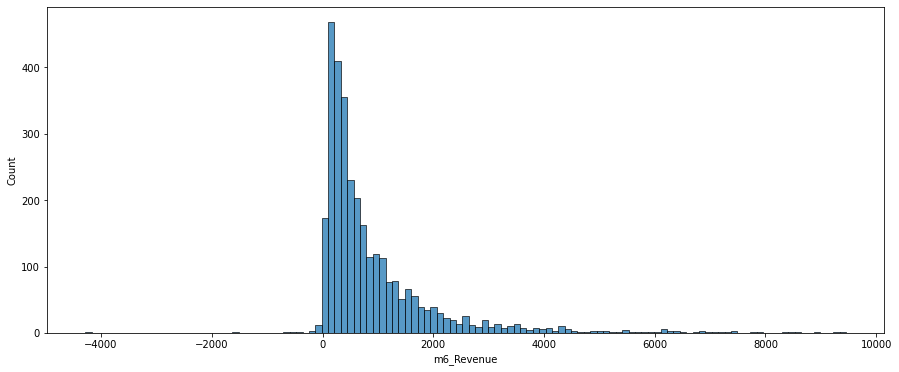

In [129]:
plt.subplots(figsize=(15, 6))
sns.histplot(df_user_6['m6_Revenue'])

In [130]:
df_merge = pd.merge(df_user, df_user_6m, on='CustomerID', how='left')
df_merge = df_merge.fillna(0)

df_graph = df_merge.query("m6_Revenue < 30000")

In [131]:
df_graph

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment,m6_Revenue
0,14620.0,12,3,30,0,393.28,0,3,Low-Value,0.00
1,15194.0,6,3,64,0,1439.02,0,3,Low-Value,3232.20
2,18044.0,5,3,57,0,808.96,0,3,Low-Value,991.54
3,18075.0,12,3,35,0,638.12,0,3,Low-Value,1322.75
4,15241.0,0,3,64,0,947.55,0,3,Low-Value,791.04
...,...,...,...,...,...,...,...,...,...,...
1832,16422.0,4,3,129,1,10348.13,2,6,High-Value,16756.31
1834,13798.0,4,3,122,1,11105.20,2,6,High-Value,12913.99
1837,15311.0,4,3,522,2,16309.61,2,7,High-Value,29313.15
1838,13089.0,5,3,452,2,11757.87,2,7,High-Value,26013.37


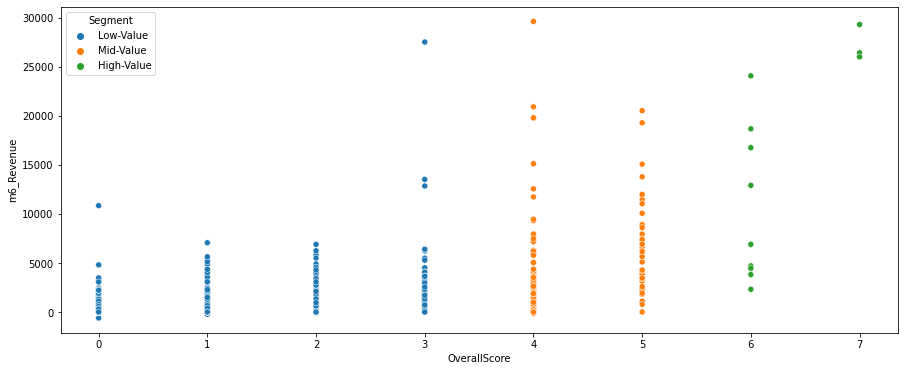

In [132]:
plt.subplots(figsize=(15, 6))
sns.scatterplot(data=df_graph, x='OverallScore', y='m6_Revenue', hue="Segment")

Положительная корреляция здесь заметна. Высокий балл RFM означает высокий LTV.
Прежде чем строить модель машинного обучения, нам нужно определить, в чем заключается тип этой проблемы машинного обучения. 

LTV сам по себе является проблемой регрессии. Модель машинного обучения может предсказать значение LTV в $. Но здесь нам нужны сегменты LTV, потому что это делает его более действенным и легким в понимании. Применяя кластеризацию K-средних, мы можем идентифицировать наши существующие группы LTV и строить сегменты поверх них.

Нам необходимо по-разному относиться к клиентам, основываясь на их прогнозируемом LTV. Для этого примера мы применим кластеризацию и будем делить на 3 сегмента (количество сегментов зависит от динамики и целей вашего бизнеса).:

* Низкий LTV
* Средний LTV
* Высокий LTV

In [133]:
df_merge = df_merge[df_merge['m6_Revenue']<df_merge['m6_Revenue'].quantile(0.99)]

kmeans = KMeans(n_clusters=3)
kmeans.fit(df_merge[['m6_Revenue']])
df_merge['LTVCluster'] = kmeans.predict(df_merge[['m6_Revenue']])

df_merge = order_cluster('LTVCluster', 'm6_Revenue', df_merge, True)

df_cluster = df_merge.copy()

df_cluster.groupby('LTVCluster')['m6_Revenue'].describe()


,count,mean,std,min,25%,50%,75%,max
LTVCluster,,,,,,,,
0,1394.0,396.137189,419.891843,-609.40,0.000,294.220,682.4300,1429.87
1,371.0,2492.794933,937.341566,1445.31,1731.980,2162.930,3041.9550,5287.39
2,56.0,8222.565893,2983.572030,5396.44,6151.435,6986.545,9607.3225,16756.31


2-лучший показатель со средним 8,2 тыс. LTV, в то время как 0 - худший показатель с 396.

* Нужно заняться разработкой некоторых функций. Мы должны преобразовать категориальные столбцы в числовые столбцы.
* Мпроверим корреляцию функций с нашей меткой, кластерами LTV.
* разделим наш набор данных и обозначим y как LTVCluster. Мы используем X для прогнозирования y.
* Создадим обучающий и тестовый набор данных. Обучающий набор будет использоваться для построения модели машинного обучения. Мы применим нашу модель к тестовому набору, чтобы увидеть его реальную производительность.

In [134]:
df_class = pd.get_dummies(df_cluster)

In [135]:
corr_matrix = df_class.corr()
corr_matrix['LTVCluster'].sort_values(ascending=False)

LTVCluster            1.000000
m6_Revenue            0.845933
Revenue               0.600491
RevenueCluster        0.476024
Segment_Mid-Value     0.417662
OverallScore          0.379033
FrequencyCluster      0.366366
Frequency             0.359601
RecencyCluster        0.236899
Segment_High-Value    0.145587
CustomerID           -0.028401
Recency              -0.237249
Segment_Low-Value    -0.442020
Name: LTVCluster, dtype: float64

Мы видим, что 6-месячный доход, частота и результаты RFM будут полезны для наших моделей машинного обучения.

In [136]:
X = df_class.drop(['LTVCluster','m6_Revenue'],axis=1)
y = df_class['LTVCluster']

In [137]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=56)

In [138]:
ltv_xgb_model = xgb.XGBClassifier(max_depth=5, learning_rate=0.1,objective= 'multi:softprob',n_jobs=-1).fit(X_train, y_train)
print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(ltv_xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(ltv_xgb_model.score(X_test[X_train.columns], y_test)))


Accuracy of XGB classifier on training set: 0.91
Accuracy of XGB classifier on test set: 0.86


In [139]:
y_pred = ltv_xgb_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.97      0.92        70
           1       0.80      0.44      0.57        18
           2       0.75      0.75      0.75         4

    accuracy                           0.86        92
   macro avg       0.81      0.72      0.75        92
weighted avg       0.85      0.86      0.84        92



Самый большой кластер, который у нас есть, - это кластер 0, который составляет 76,5% от общей базы. Если мы слепо скажем, что каждый клиент принадлежит к кластеру 0, то наша точность составит 76,5%.
87% против 76,5% говорят нам, что наша модель машинного обучения полезна, но наверняка нуждается в некотором улучшении. Мы должны выяснить, где модель дает сбой.

для кластера 0 (низкий LTV), если модель сообщает нам, что этот клиент принадлежит к кластеру 0, 90 из 100 будут правильными (точность). И модель успешно идентифицирует 97% фактических клиентов кластера 0 (полнота). Нам действительно нужно улучшить модель для других кластеров. Например, мы обнаруживаем 80% клиентов среднего уровня LTV. Возможные действия по улучшению этих моментов:

* Добавление дополнительных функций и улучшение разработки функций
* Попробуйте другие модели, отличные от XGBoost
* Примените настройку гиперпараметров к текущей модели
* По возможности добавьте в модель дополнительные данные